# Temporal Difference and Least Squares Temporal Difference Learning

This notebook is an implementation of the Temporal Difference and Least Squares Temporal Difference Learning algorithms. 

TD algorithm: https://en.wikipedia.org/wiki/Temporal_difference_learning

# Load packages

In [31]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define common functions

In [33]:
def value(Xt, At, N=100):
    ''' Calculates immediate reward in a given state'''
    return -((Xt /N)**2) - costs[int(At)]

def trunc(Xt, It, St, N= 100):
    ''' Transitions to next state through sampling from input and output binomial distributions (output probability q depends on action)'''
    X = Xt + It - St
    res =  min(N, max(X, 0))
    if res >= 100: res = 99
    return res

# FEATURE MAPS

def fine_feature(x):
    '''Transforms state space (queue length 1-100) into a 100-dimensional space'''
    phi = np.array([int(i==x) for i in range(100)])
    return phi

def coarse_feature(x):
    '''Transforms state space (queue length 1-100) into a lower-dimensional (20d) space'''
    phi = np.array([int(np.floor(x/5)==i)+(x==100)*(i==19) for i in range(20)])
    return phi

def piecewise(x):
    '''Transforms state space (queue length 1-100) into a lower-dimensional (40d) space'''
    phi = np.array([0. for i in range(40)])
    l = int(x/5) if x < 100 else 19
    phi[l] = 1
    phi[l+20] = (x-5*l)/5
    return phi

# Tests
print('Value test for 30 with a low action: \n', value(30, 0))
print('Add one to a queue of 9: \n', trunc(9,1,0))
print('Remove one from a queue of 100: \n', trunc(100,0, 1))
print('Add one to a queue of 100: \n', trunc(100,1,0))

Value test for 30 with a low action: 
 -0.09
Add one to a queue of 9: 
 10
Remove one from a queue of 100: 
 99
Add one to a queue of 100: 
 99


# Temporal Difference learning

In [165]:
# Temporal-Difference (TD) Prediction or TD(0)
def td_prediction(env, num_episodes, policy, feature, transitions,
                  a=10**4, b=10**5, T = 10 **4, gamma=0.99, p = 0.5):
    """
    Implementation for Temporal-Difference (TD) Prediction or TD(0).
    
    ARGUMENTS
    ---------------------------
        - env: This is the range 0-100, length of the queue.
        - num_episodes: This is the number of episodes that are generated through agent-environment interaction.
        - policy: This is a 1D numpy array with policy.shape equal to the number of states (100). policy[s] 
                  returns the action that the agent chooses when in state s.
        - Feature: describes the mapping from state space to feature space- 'fine', 'coarse' or 'piecewise'. These are defifned as 
          separate functions.
        - Transition: A list of points (ts) at which we record results
        - T: Number of updates in each episode
        - a,b: These are the parameters from which step-size is derived for the update step.
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default value: 0.99).
    
    RETURNS
    ---------------------------
        - V_list: A list of Vs for each transition;
                - V: This is a list where V[s] is the estimated value of state s.
        
    """
    make_feature = features[feature]
    
    # Initialize empty V_list for value function for each transition... and Value function itself
    V_list = []
    V = np.zeros(len(make_feature(0)))
     
    
    # Iterate through episodes
    for i_episode in range(1, num_episodes + 1):
            
        # Resets the state of the environment and returns an initial observation.
        state = 99
        
        # T loop
        for t in range(0, T+1):
            
            # Choose action A
            action = policy[state]
            q = action_space[int(action)]
            
            # Run one timestep of the environment's dynamics (take action A, observe R, S')
            next_state = trunc(state, np.random.binomial(1,p), np.random.binomial(1,q))
            reward = value(state, action)
            
            # Calculate step size
            alpha = a/(t+b)
            
            # Perform updates  
               
            delta = reward +  (gamma * np.dot(V, make_feature(next_state))) - np.dot(V, make_feature(state))
            V += ([(alpha * delta)] * len(make_feature(0))) * np.array(make_feature(state) )  
             
            if t in transitions:
                V_list.append(list(V))
                
            # Update the current state to next state
            state = next_state
 
                
    return V_list

# Least Squares Temporal Difference learning

In [157]:
# Temporal-Difference (TD) Prediction or TD(0)
def lstd_prediction(env, num_episodes, policy, feature, transitions,
             T = 10 **4, gamma=0.99, p = 0.5):
    """
    Implementation for Least Squares Temporal-Difference (TD) Prediction or LSTD.
    
    ARGUMENTS
    ---------------------------
        - env: This is the range 0-100, length of the queue.
        - num_episodes: This is the number of episodes that are generated through agent-environment interaction.
        - policy: This is a 1D numpy array with policy.shape equal to the number of states (100). policy[s] 
                  returns the action that the agent chooses when in state s.
        - Feature: describes the mapping from state space to feature space- 'fine', 'coarse' or 'piecewise'. These are defifned as 
          separate functions.
        - Transition: A list of points (ts) at which we record results
        - T: Number of updates in each episode
        - a,b: These are the parameters from which step-size is derived for the update step.
        - gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default value: 0.99).
    
    RETURNS
    ---------------------------
        - V_list: A list of Vs for each transition;
                - V: This is a list where V[s] is the estimated value of state s.
        
    """
    make_feature = features[feature]
    
    # Initialize empty V_list for value function for each transition... and Value function itself
    LSTD_V_list = []
    LSTD_A = np.zeros([len(make_feature(0)), len(make_feature(0))])
    LSTD_B = np.zeros([len(make_feature(0)), 1])
    
    
    # Iterate through episodes
    for i_episode in range(1, num_episodes + 1):
            
        # Resets the state of the environment
        state = 99
        
        # T loop
        for t in range(0, T+1):
            
            # Choose action A
            action = policy[state]
            q = action_space[int(action)]
            
            # Run one timestep of the environment's dynamics (take action A, observe R, S')
            next_state = trunc(state, np.random.binomial(1,p), np.random.binomial(1,q))
            reward = value(state, action)
            
            # Perform updates for TD  and LSTD            
            LSTD_A += make_feature(state).reshape(-1,1)@(make_feature(state) - gamma*make_feature(next_state)).reshape(-1,1).T
            LSTD_B += reward * make_feature(state).reshape(-1,1) 

            if t in transitions:
                
                LSTD_V = np.linalg.inv(LSTD_A+np.diag([0.00001 for _ in range(len(LSTD_B))]))@LSTD_B
                LSTD_V = [x[0] for x in LSTD_V]
                LSTD_V_list.append(LSTD_V)
                
                
            # Update the current state to next state
            state = next_state
            
          
    return LSTD_V_list

# Set up problem

In [162]:
# Define spaces
state_space = np.arange(0,100,1)
action_space = [ 0.51,  0.6] # q probabilities according to action

costs = [0,  0.05 ] # costs associated with different actions

# Define policies for evaluation
lazy_policy = np.zeros(100)
agressive_policy =  list(np.zeros(50)).append(x for x in np.ones(50))

# Describe variables for evaluation
policies = {'Lazy': lazy_policy, 'Aggressive': aggressive_policy}
trans = [100,200, 300, 400]
features = [fine_feature, coarse_feature, piecewise]


# Tests
print('State space: \n', state_space)

State space: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [169]:
td_results = pd.DataFrame()

for p_name, pol in policies.items():
    
    for f, feat in enumerate(features):
        
        V_list = td_prediction(state_space, 1, policy = pol, feature = f, transitions = trans, T = 10**2)
        
        for T, V in enumerate(V_list):
            
            V_df = pd.DataFrame([state_space, list([float(feat(x)@V) for x in state_space])]).transpose()
                       
            V_df.columns = ['state', 'value']
            V_df.loc[:, 'feat'] = feat
            V_df.loc[:, 'pol'] = p_name
            V_df.loc[:, 'transition'] = trans[T]
        
            td_results = pd.concat([td_results, V_df])
            
# results.to_csv('td_results.csv', index = False)

td_results.head(5)

,state,value,feat,pol,transition
0,0.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100
1,1.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100
2,2.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100
3,3.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100
4,4.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100


In [170]:
lstd_results = pd.DataFrame()

for p_name, pol in policies.items():
    
    for f, feat in enumerate(features):
        
        make_feature = features[f]
        
        V_list = lstd_prediction(state_space, 1, policy = pol, feature = f, transitions = trans, T = 10**2)
                              
        for j, V in enumerate(V_list):
             
            V_df = pd.DataFrame([state_space, list([float(make_feature(x)@V) for x in state_space])]).transpose()
                
            V_df.columns = ['state', 'value']
            V_df.loc[:, 'feat'] = feat
            V_df.loc[:, 'pol'] = p_name
            V_df.loc[:, 'transition'] = trans[j]
        
            lstd_results = pd.concat([lstd_results, V_df])
            
# results.to_csv('lstd_results.csv', index = False)

lstd_results.head(5)

,state,value,feat,pol,transition
0,0.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100
1,1.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100
2,2.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100
3,3.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100
4,4.0,0.0,<function fine_feature at 0x7f9bd9363830>,Lazy,100


# Plot results

In [173]:
# td_results = pd.read_csv('td_results.csv')
# lstd_results = pd.read_csv('lstd_results.csv')

td_results.loc[:, 'Algorithm'] =  'TD'
lstd_results.loc[:, 'Algorithm'] = 'LSTD'

results = pd.concat([td_results, lstd_results])

results['Policy_Algorithm'] = results['pol'] + results['Algorithm']

results.columns = ['State', 'Value', 'Feature_map', 'Policy', 'Transition', 'Algorithm', 'Policy_Algorithm']

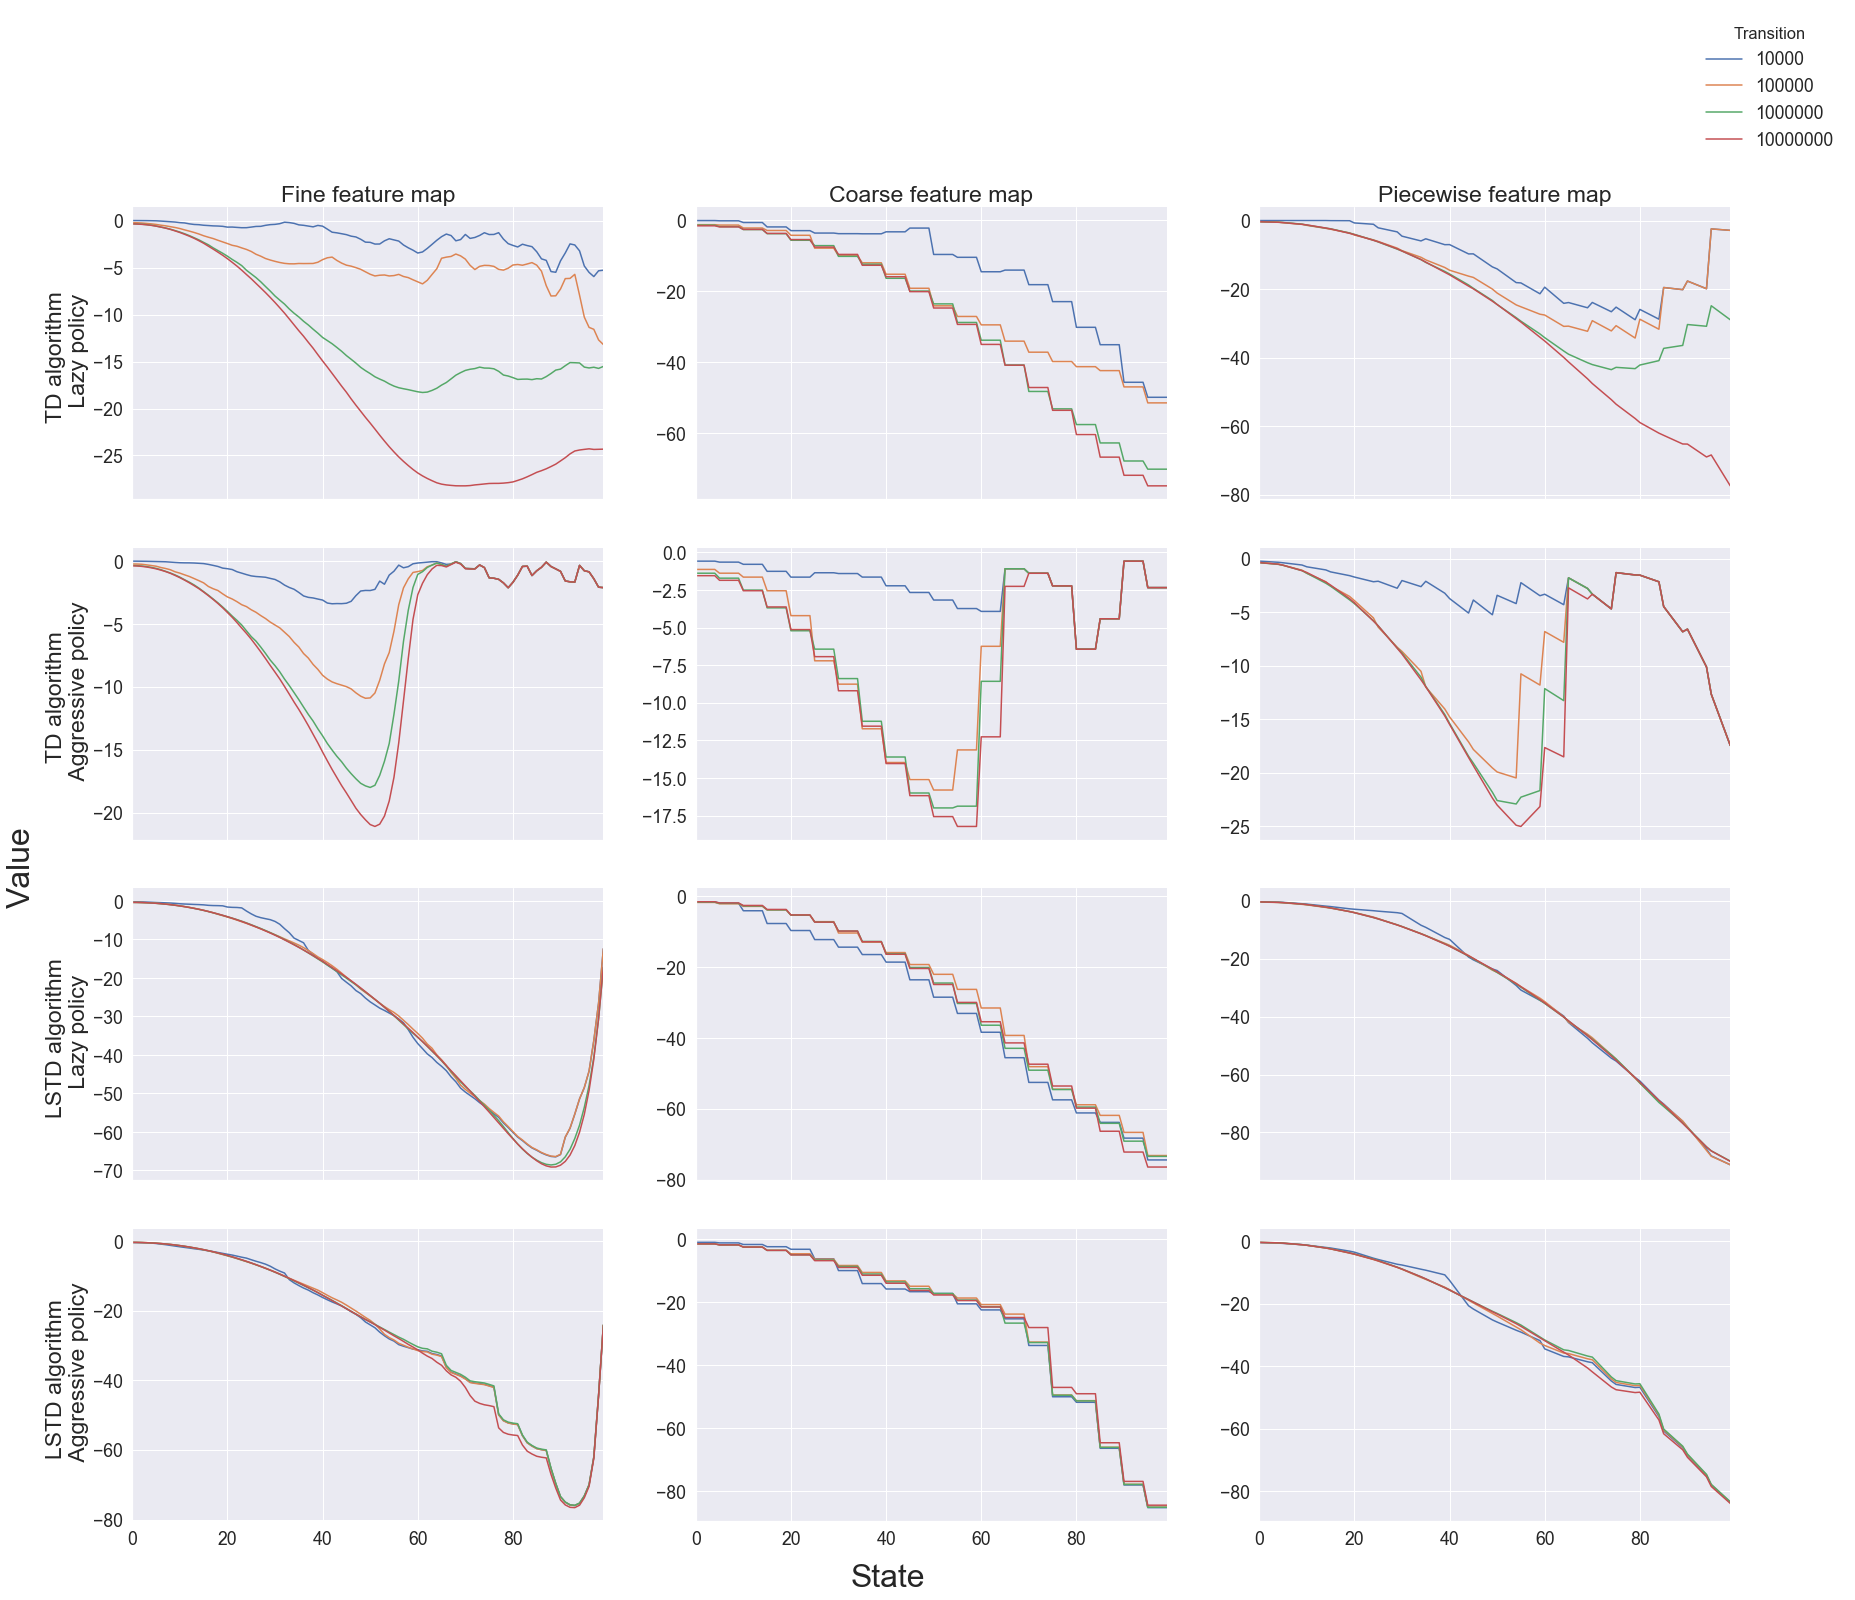

In [174]:
sns.set(rc={'figure.figsize':(15,15)}, font_scale=1.6)
sns.set_style('darkgrid')

g = sns.FacetGrid(results,
                  col="Feature_map", row = 'Policy_Algorithm', hue = 'Transition',
                  sharex = True, sharey = False, height = 5, aspect = 1.5).set(xlim = (0,99))

g.map(sns.lineplot,'State','Value').set_titles("{col_name} features under {row_name} policy").add_legend(markerscale=10,
                                                                                                        bbox_to_anchor=(1.05, 1.05))


g.set_axis_labels('', '') 
g.fig.text(x=0, y=0.5, verticalalignment='center',  s='Value', size=32,  rotation=90) # Overall y label
g.fig.text(x=0.5, y=0,  horizontalalignment='center', s='State',  size=32) #overall xlabel


x_titles = ['Fine feature map', 'Coarse feature map', 'Piecewise feature map', '','','','','','','','','']
y_titles = ['TD algorithm \n Lazy policy', '', '', 'TD algorithm \n Aggressive policy','','','LSTD algorithm \n Lazy policy',
            '','','LSTD algorithm \n Aggressive policy','','']

for i, ax in enumerate(g.axes.flat):
    ax.set_title(x_titles[i], fontsize='large')
    ax.set_ylabel(y_titles[i], fontsize='large')
    
plt.tight_layout(pad = 2)